In [2]:
import cv2
import os
import numpy as np
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve,classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


In [3]:
# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image and return the cropped face images
def crop_face(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60,60))
    
    # Crop and store the detected faces
    cropped_face=[]
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        cropped_face.append(face)
    
    return cropped_face





In [4]:
lstfolder=["person_1","Abdelrahman_Sameh","person_2","Beshara_Safwat","person_3","Mariam_Mounier","person_4","Osamah_Faisal","person_5","person_6","Shuaib_Saleh","person_7"]
targetDir1 = "Dataset/TrainData"
targetDir2 = "Dataset/TestData"

i = 0
for lst in lstfolder:
    listFiles = glob.glob(r"Dataset\{}\*".format(lst))
    counter = 0
    
    for file in listFiles:
        try:
            
            flag = not os.path.exists(f"{targetDir1}/{lstfolder[i]}") or not os.path.exists(f"{targetDir2}/{lstfolder[i]}")
          # Example usage with an image file
            image_path = file
            image = cv2.imread(image_path)
            image = cv2.resize(image,(300,300))
            cropped_face = crop_face(image)
            cropped_face = np.array(cropped_face[0])

            if flag:
               os.mkdir(os.path.join(targetDir1, lstfolder[i]))
               os.mkdir(os.path.join(targetDir2, lstfolder[i]))
               if (counter < 6):
                    cv2.imwrite(f'{targetDir2}/{lstfolder[i]}/cropped_face_{counter}.jpg', cropped_face)

               else:
                    cv2.imwrite(f'{targetDir1}/{lstfolder[i]}/cropped_face_{counter}.jpg', cropped_face)


            if not flag:
               if (counter < 6):
                  cv2.imwrite(f'{targetDir2}/{lstfolder[i]}/cropped_face_{counter}.jpg', cropped_face)

               else:
                   cv2.imwrite(f'{targetDir1}/{lstfolder[i]}/cropped_face_{counter}.jpg', cropped_face)

            
            
            counter += 1
            
        except:
            continue
    i+=1 
      
            


In [5]:
train_images = []
train_labels = []

# Iterate over the folders for each person
for person_folder in os.listdir(targetDir1):
    
        person_images = os.listdir(os.path.join(targetDir1, person_folder))
        # "Dataset/TrainData/person{i}"
        train_images.extend([cv2.imread(os.path.join(targetDir1, person_folder, img),0) for img in person_images])
        train_labels.extend([person_folder] * len(person_images))

In [6]:
print(len(train_images))
print(len(train_labels))

275
275


In [7]:
test_images = []
test_labels = []

# Iterate over the folders for each person
for person_folder in os.listdir(targetDir2):
    
        person_images = os.listdir(os.path.join(targetDir2, person_folder))
        test_images.extend([cv2.imread(os.path.join(targetDir2, person_folder, img),0) for img in person_images])
        test_labels.extend([person_folder] * len(person_images))

In [85]:
print(len(test_images))
print(len(test_labels))

72
72


In [8]:

trainData = []

for i in range(len(train_images)):

    image = train_images[i]
    image = cv2.resize(image,(100,100))

    # Convert the image to a NumPy array
    image_array = np.array(image)
    trainData.append(image_array)


trainData = np.array(trainData)
print(trainData.shape)

# Reshape the 2D images into 1D feature vectors
trainData = trainData.reshape(trainData.shape[0], -1)
print(trainData.shape)

# Normalize the feature vectors
mean_face = np.mean(trainData, axis=0)
trainData = trainData - mean_face

# Compute the covariance matrix
cov_matrix = np.dot(trainData.T, trainData)
cov_matrix /= trainData.shape[0] - 1

# Perform eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
# Sort the eigenvectors based on eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]
magnitude = np.linalg.norm(eigenvectors)
normalized_eigenvectors = eigenvectors / magnitude

# Choose the number of principal components 
n_components = 100
principal_components = normalized_eigenvectors[:, :n_components]

# Project the training data onto the principal components
trainData_pca = np.dot(trainData, principal_components)



(275, 100, 100)
(275, 10000)


In [9]:
import csv

# Example 2D array
data = principal_components
data2 = mean_face

# Path to the CSV file
csv_file = 'principal_components.csv'
csv_file2 = 'mean_face.csv'
# Write the 2D array to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# Write the 1D array to the CSV file
with open(csv_file2, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(data2)


print("CSV file created successfully.")

CSV file created successfully.


In [18]:
testData = []

for i in range(len(test_images)):

    image = test_images[i]
    image = cv2.resize(image,(100,100))

    # Convert the image to a NumPy array
    image_array = np.array(image)
    testData.append(image_array)


testData = np.array(testData)
print(testData.shape)

# Reshape the 2D images into 1D feature vectors
testData = testData.reshape(testData.shape[0], -1)
print(testData.shape)

# Normalize the feature vectors
# mean_face = np.mean(testData, axis=0)
testData = testData - mean_face

# Project the test data onto the principal components
testData_pca = np.dot(testData, principal_components)
print(testData_pca.shape)


(72, 100, 100)
(72, 10000)
(72, 100)


In [19]:
print(len(testData_pca[0]))

100


In [24]:
# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=2)

# Fit the classifier on the PCA-transformed training data
model=knn.fit(trainData_pca, train_labels)

# Predict labels for the test data
labels_pred = model.predict(testData_pca)



# Calculate accuracy
accuracy = accuracy_score(test_labels, labels_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9583333333333334


In [26]:
# print(test_labels)
# print(labels_pred)

In [27]:
from joblib import dump
#Save the model

model_filename = 'faceRecognition'
dump(model,model_filename)

['faceRecognition']

In [28]:
from sklearn import metrics
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    # plt.figure(1)
    plt.figure(figsize=(10,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ["person_1","Abdelrahman_Sameh","person_2","Beshara_Safwat","person_3","Mariam_Mounier","person_4","Osamah_Faisal","person_5","person_6","Shuaib_Saleh","person_7"]
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def report_performance(model):

    model_test = model.predict(testData_pca)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(test_labels, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(test_labels, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    plot_confusion_metrix(test_labels, model_test)

def roc_curves(model):

    predictions_test = model.predict_proba(testData_pca)
    n_classes = len(model.classes_)
    binarized_labels = label_binarize(test_labels, classes=model.classes_)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predictions_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), predictions_test.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['darkorange', 'green', 'blue','red','yellow','cyan','orange','pink','navy','brown','darkgray','magenta']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve class %d (area = %0.2f)' % (i, roc_auc[i]))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=2,
             label='Micro-Average ROC curve (area = %0.2f)' % roc_auc["micro"])

    # Plot random guess line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot limits, labels, and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Multiclass')
    plt.legend(loc="lower right")
    plt.show()







Confusion Matrix:
[[6 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 0 0 1 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 6]]


Classification Report: 
                   precision    recall  f1-score   support

Abdelrahman_Sameh       1.00      1.00      1.00         6
   Beshara_Safwat       1.00      0.67      0.80         6
   Mariam_Mounier       1.00      1.00      1.00         6
    Osamah_Faisal       0.75      1.00      0.86         6
     Shuaib_Saleh       1.00      1.00      1.00         6
         person_1       1.00      1.00      1.00         6
         person_2       1.00      1.00      1.00         6
         person_3       1.00      1.00      1.00         6
         person_4       1.00      1.00      1.00         6
         person_5       0.86      1.00

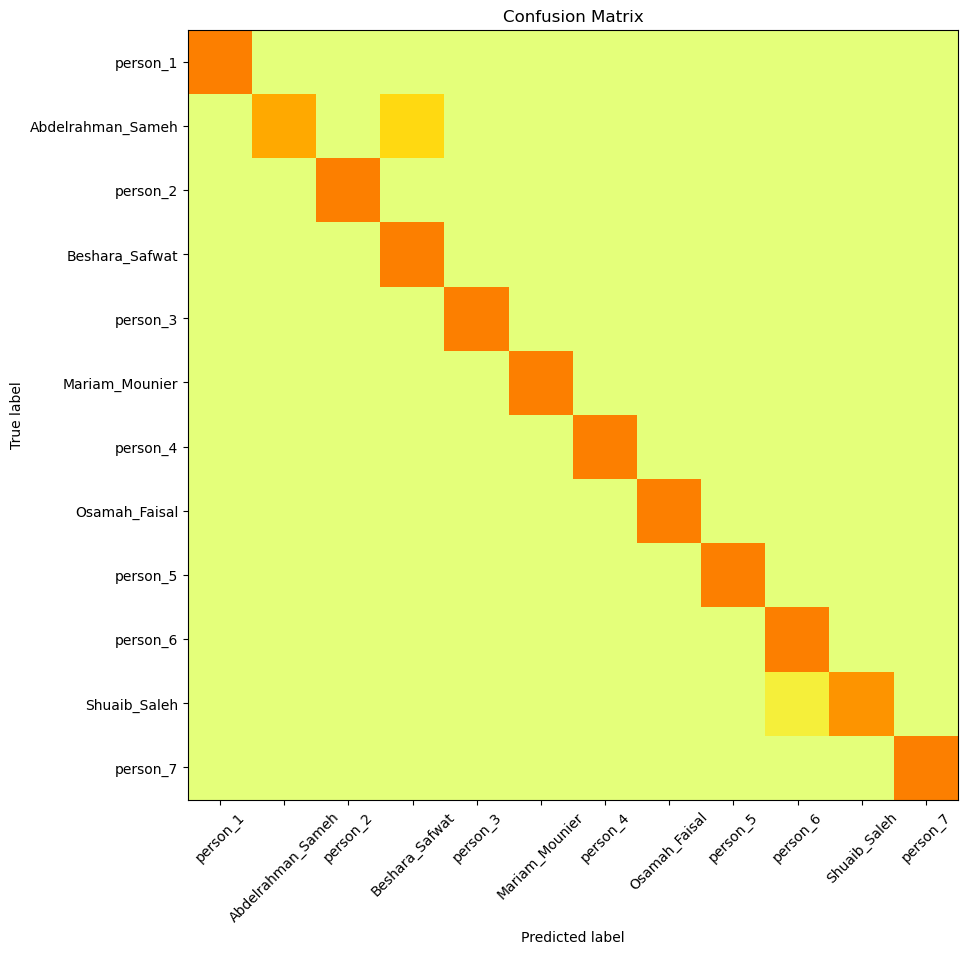

In [30]:
report_performance(model)
# len(model.classes_)

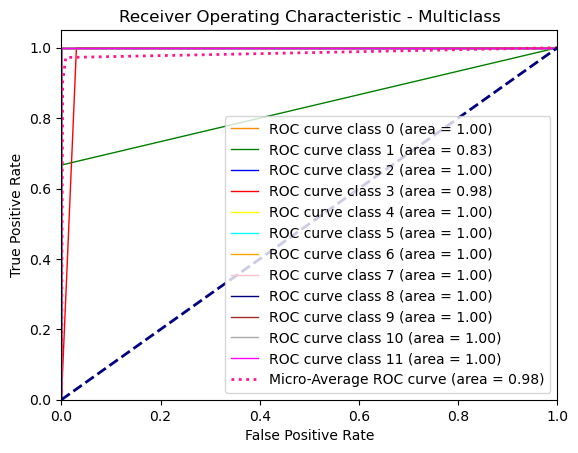

In [31]:
roc_curves(model)
